Original: (1024, 768)
GT count: 299
Resized: (1024, 768)
Full density shape: (768, 1024)
Full density sum: 298.0
DS shape: (96, 128)
DS density sum: 296.76
Image tensor: torch.Size([3, 768, 1024])
Density tensor: torch.Size([1, 96, 128])


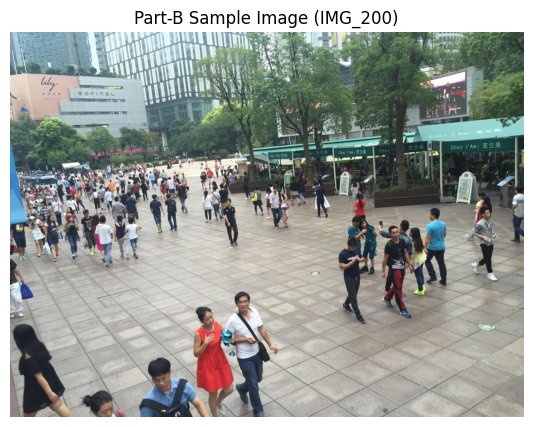

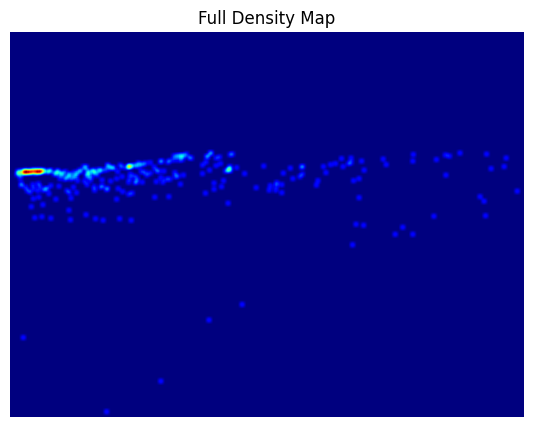

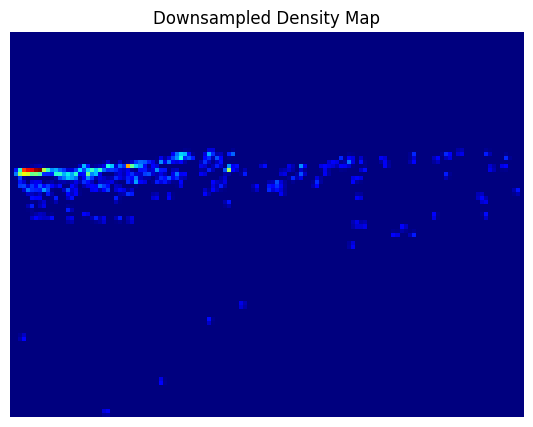

In [14]:
##Set paths
trainB_images = r"C:\Users\anany\OneDrive\Desktop\Deepvision-Crowd-Monitor\ShanghaiTech_Crowd_Counting_Dataset\part_B_final\train_data\images"
trainB_gts    = r"C:\Users\anany\OneDrive\Desktop\Deepvision-Crowd-Monitor\ShanghaiTech_Crowd_Counting_Dataset\part_B_final\train_data\ground_truth"
import os
import numpy as np
import cv2
import torch
import scipy.io as sio
from PIL import Image          # <--- IMPORTANT
import matplotlib.pyplot as plt
import torchvision.transforms as T

img_name = "IMG_200.jpg"
mat_name = "GT_IMG_200.mat"

img_path = os.path.join(trainB_images, img_name)
mat_path = os.path.join(trainB_gts, mat_name)

##Load image + GT
img = Image.open(img_path).convert("RGB")
print("Original:", img.size)

mat = sio.loadmat(mat_path)
points = mat["image_info"][0][0][0][0][0]
print("GT count:", len(points))
##Resize image (1024×768)
TARGET_W, TARGET_H = 1024, 768
img_resized = img.resize((TARGET_W, TARGET_H))

scale_x = TARGET_W / img.size[0]
scale_y = TARGET_H / img.size[1]

points_scaled = points.copy().astype("float32")
points_scaled[:,0] *= scale_x
points_scaled[:,1] *= scale_y

print("Resized:", img_resized.size)

##Generate perfect full-resolution density map
def generate_density_map(points, h, w, k=(15,15), sigma=4):
    den = np.zeros((h, w), dtype=np.float32)
    for x,y in points:
        xi = int(min(w-1, max(0, x)))
        yi = int(min(h-1, max(0, y)))
        den[yi, xi] = 1
    den = cv2.GaussianBlur(den, k, sigma)
    return den

density_full = generate_density_map(points_scaled, 768, 1024)

print("Full density shape:", density_full.shape)
print("Full density sum:", round(density_full.sum(), 2))

##Downsample by 8 & multiply by 64
density_ds = cv2.resize(density_full, (1024//8, 768//8), cv2.INTER_CUBIC)
density_ds *= 64

print("DS shape:", density_ds.shape)
print("DS density sum:", round(density_ds.sum(), 2))


##Convert to PyTorch tensors
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

img_tensor = transform(img_resized)
density_tensor = torch.from_numpy(density_ds).unsqueeze(0).float()

print("Image tensor:", img_tensor.shape)
print("Density tensor:", density_tensor.shape)

##Full Visualization
plt.figure(figsize=(7,5))
plt.imshow(img_resized)
plt.title("Part-B Sample Image (IMG_200)")
plt.axis("off")
plt.show()

plt.figure(figsize=(7,5))
plt.imshow(density_full, cmap="jet")
plt.title("Full Density Map")
plt.axis("off")
plt.show()

plt.figure(figsize=(7,5))
plt.imshow(density_ds, cmap="jet")
plt.title("Downsampled Density Map")
plt.axis("off")
plt.show()





